In [1]:
#Dataset downloaded from yahoo finance( 1 Jan 13 to 31 Dec 23)
import pandas as pd
import numpy as np

raw = pd.read_csv('NIFTY-50.csv')
raw_arima = raw
raw_lstm = raw

# forecasting after the pandemic
raw= raw.iloc[1800:]
raw.describe()

,Open,High,Low,Close,Adj Close,Volume
count,913.000000,913.000000,913.000000,913.000000,913.000000,9.130000e+02
mean,16252.875686,16328.453490,16149.597510,16244.092890,16244.092890,3.802599e+05
std,2829.613365,2827.962558,2831.934412,2830.955691,2830.955691,1.916564e+05
min,8889.150391,9030.349609,8806.750000,8823.250000,8823.250000,0.000000e+00
25%,14811.849609,14890.250000,14692.450195,14823.150391,14823.150391,2.449000e+05
50%,17160.550781,17251.650391,17018.150391,17149.099609,17149.099609,2.980000e+05
75%,18094.750000,18141.400391,17992.800781,18070.050781,18070.050781,5.048000e+05
max,21737.650391,21801.449219,21678.000000,21778.699219,21778.699219,1.371800e+06


Preprocess Data
* Delete Na Values
* Delete Date, High, Low, Adj Close

In [2]:
import preprocess_a as pp

raw1=pp.remove(raw)
raw1.describe()

,Open,Close,Volume,Days
count,913.000000,913.000000,9.130000e+02,913.000000
mean,16252.875686,16244.092890,3.802599e+05,456.000000
std,2829.613365,2830.955691,1.916564e+05,263.704696
min,8889.150391,8823.250000,0.000000e+00,0.000000
25%,14811.849609,14823.150391,2.449000e+05,228.000000
50%,17160.550781,17149.099609,2.980000e+05,456.000000
75%,18094.750000,18070.050781,5.048000e+05,684.000000
max,21737.650391,21778.699219,1.371800e+06,912.000000


[8823.25, 21778.699219]


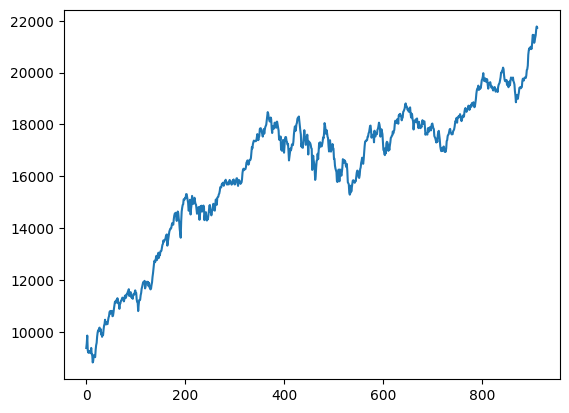

In [3]:
import diagrams as dd
dd.dig(raw1)
original_range=[min(raw1['Close']),max(raw1['Close'])]
print(original_range)

Normalise the Data between 0 to 1, using MinMaxScaler 

In [4]:
# Wont be using this cell as custom defined methods will be used
# raw2=pp.normed_data(raw1)
# dd.dig(raw2)

# # uncomment if running for the first time
# # raw2.to_csv('Nifty_preprocessed', index=False)

Creating a Linear Regression Model
* For benchmarking, on Nifty Preprocessed Data

In [5]:
# Linear Regression
import lin_reg_help as lr
import helperfunc as hf

X_train, X_test, y_train, y_test, y_range = hf.test_train_split_lin_reg(raw1)
lr_model = lr.model(pd.DataFrame(X_train), pd.DataFrame(y_train))

In [6]:
# predict prices
predict_test = lr.predict_index(lr_model, pd.DataFrame(X_test), y_range)
predict_train = lr.predict_index(lr_model, pd.DataFrame(X_train), y_range)
predict_all = lr.predict_index (lr_model, pd.DataFrame(raw1['Days']),y_range)

In [7]:
# scaling actual values
actual_test, _  = hf.scl( y_test, y_range)
actual_train, _ = hf.scl( y_train, y_range)
actual_all, _ =  hf.scl(raw1['Close'], y_range)

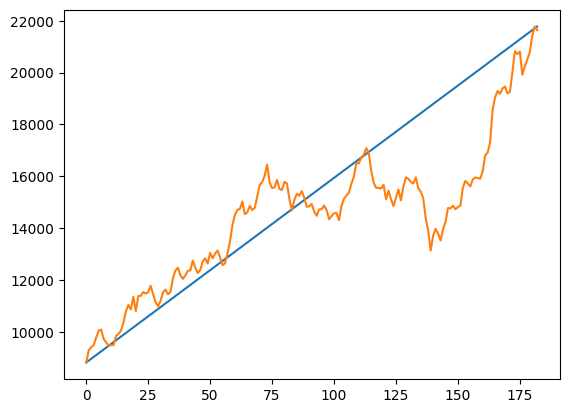

In [8]:
dd.digvs2(predict_test,actual_test, np.arange(len(actual_test)))

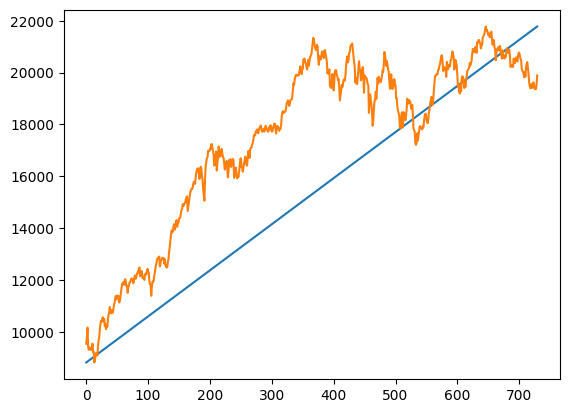

In [9]:
dd.digvs2(predict_train, actual_train, np.arange(len(actual_train)))

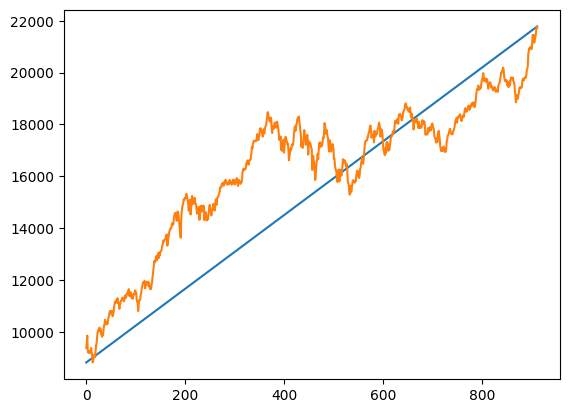

In [10]:
dd.digvs2(predict_all, actual_all, np.arange(len(actual_all)))

Evaluating the model Parameters
- RMSE on training and testing index

In [11]:
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(actual_train,predict_train)
print(rmse_train)
rmse_test = mean_squared_error(actual_test, predict_test)
print(rmse_test)
rmse_all = mean_squared_error(actual_all, predict_all)
print(rmse_all)

8006937.926474176
4248730.598914596
3773621.859947846


Creating ARIMA model

In [12]:
print(raw_arima.describe())
raw_arima = pp.remove(raw_arima)


X_train_arima, X_test_arima, y_train_arima, y_test_arima = hf.test_train_split_arima(raw_arima)

               Open          High           Low         Close     Adj Close  \
count   2700.000000   2700.000000   2700.000000   2700.000000   2700.000000   
mean   11364.825725  11418.140963  11292.118393  11356.717970  11356.717970   
std     4159.661856   4173.421486   4139.054223   4158.403861   4158.403861   
min     5233.450195   5317.700195   5118.850098   5285.000000   5285.000000   
25%     8172.975098   8213.499756   8123.375122   8170.649902   8170.649902   
50%    10488.925293  10537.100097  10431.799805  10479.250000  10479.250000   
75%    14932.824951  14990.312744  14774.962891  14907.149903  14907.149903   
max    21737.650391  21801.449219  21678.000000  21778.699219  21778.699219   

             Volume  
count  2.700000e+03  
mean   2.935654e+05  
std    1.950139e+05  
min    0.000000e+00  
25%    1.669750e+05  
50%    2.316500e+05  
75%    3.460500e+05  
max    1.811000e+06  


In [13]:
import ARIMA_help as ah
ah.check_stationary(y_train_arima)

P Value :  0.9939197181006326
Lags used :  12


In [14]:
# ah.check_stationary((raw_arima['Close']-raw_arima['Close'].shift(1)).dropna())
ah.check_stationary((y_train_arima-y_train_arima.shift(1)).dropna())

P Value :  4.475024143409621e-23
Lags used :  11


In [15]:
# ArimaModel = ah.ARIMA_model((y_train_arima-y_train_arima.shift(1)).dropna(), 5,1,0)


In [16]:
# print(ArimaModel.summary())

In [17]:
# predict_test_arima = ArimaModel.predict(start =len(X_train_arima)+1, end = (len(X_train_arima)+len(X_test_arima)) )
# predict_test_arima = list(hf.scl(predict_test_arima, y_range_arima)[0])
# actual_test_arima = list(hf.scl(y_test_arima, y_range)[0])


# import matplotlib.pyplot as plt
# fig, ax = plt.subplots()
# ax.plot(predict_test_arima)

Creating ARIMAx Model

Creating a LSTM model